# Opti Pipe

In [1]:
from opti_pipe import Model, Floor, Distributor,Node,NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter,HeuristicRouter

Domain language

* inputs are always hot (outputs cooler)

In [2]:
config = load_config()

In [3]:
floor = Floor(config=config,corners=[(0,0),(0,5),(5,5),(5,0)])

distributor = Distributor(config=config,nodes=(
    Node(config,2.0,0,node_type=NodeType.INPUT),
    Node(config,2.2,0,node_type=NodeType.OUTPUT),
    Node(config,2.4,0,node_type=NodeType.INPUT),
    Node(config,2.6,0,node_type=NodeType.OUTPUT),
    Node(config,2.8,0,node_type=NodeType.INPUT),
    Node(config,3.0,0,node_type=NodeType.OUTPUT)),
    heat_per_node=1)

room_connections = (RoomConnection(config,output=Node(config,0,3.75,node_type=NodeType.OUTPUT),input=Node(config,0,3.5,node_type=NodeType.INPUT),heat_loss=0.8),
                    RoomConnection(config,output=Node(config,5,3,node_type=NodeType.OUTPUT),input=Node(config,5,3.25,node_type=NodeType.INPUT),heat_loss=0.5),
                    RoomConnection(config,output=Node(config,2.6,5,node_type=NodeType.OUTPUT),input=Node(config,2.4,5,node_type=NodeType.INPUT),heat_loss=0.3))


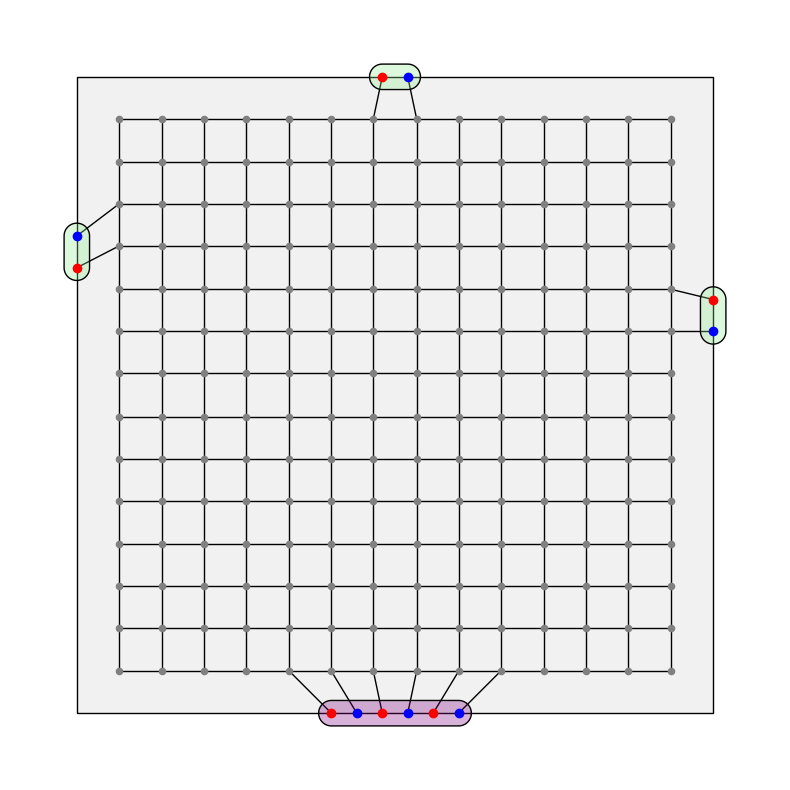

In [4]:
def get_model():
    model = Model(
        config = config,
        target_heat_input=100,
        floor=floor,
        distributor=distributor,
        room_connections=room_connections)

    grid_size = 0.3
    model.add_graph(grid_size)
    return model

model = get_model()
model.render(show_graph=True)

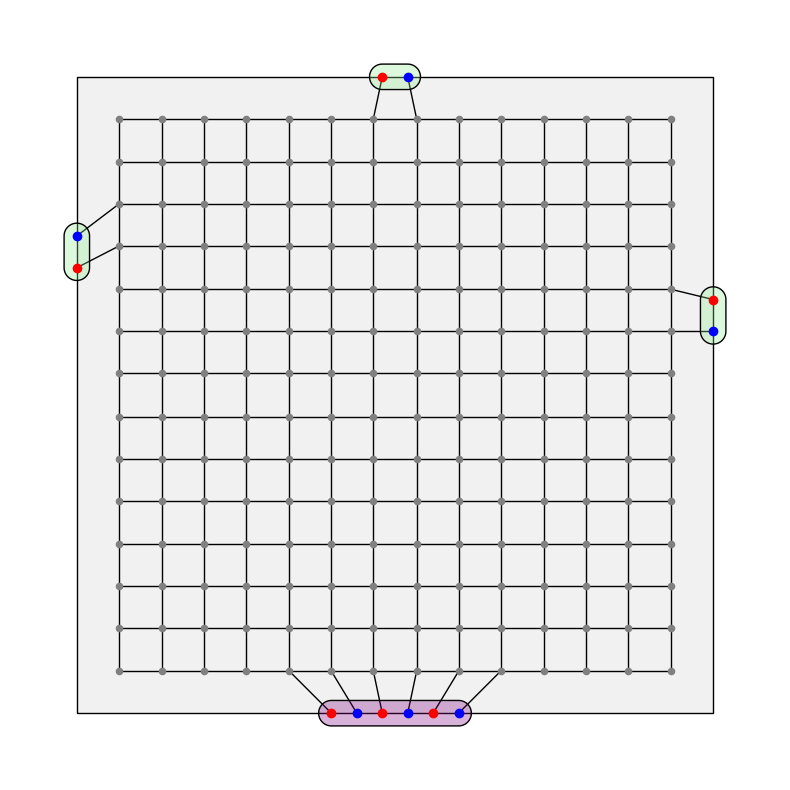

In [5]:

grid_size = 0.3
model.add_graph(grid_size)
model.render(show_graph=True)

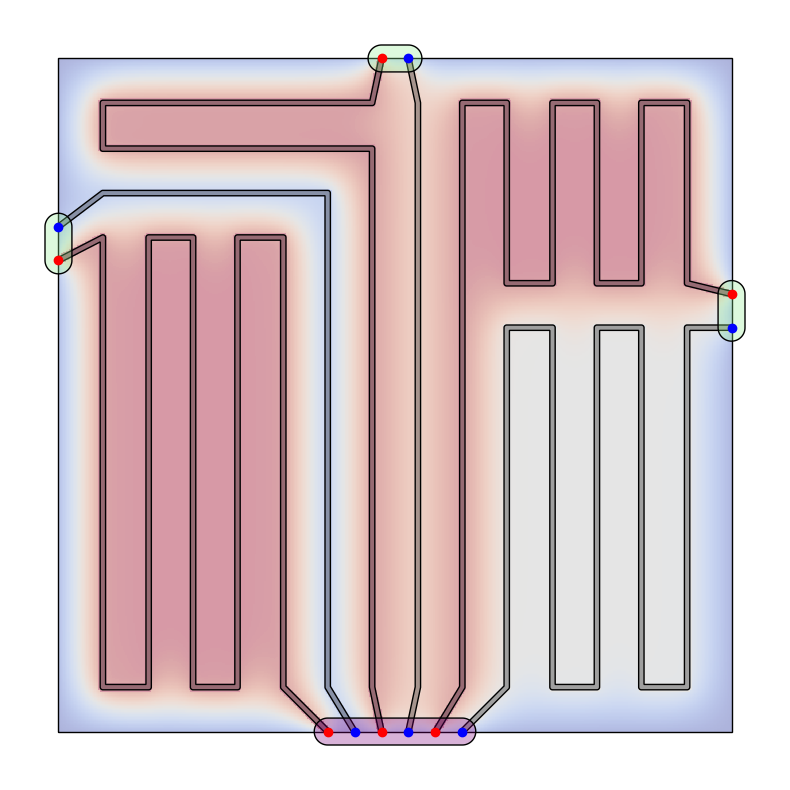

In [16]:
model = get_model()
router = HeuristicRouter(config,model,grid_size)
model = router.route()
model.render(show_graph=False,render_heat_distribution=True) 

# from opti_pipe.router import Utils
# line_string = Utils.get_centerline(model,grid_size)
# from shapely.plotting import plot_polygon
# plot_polygon(line_string)

In [7]:
import networkx as nx
from shapely.geometry import MultiPoint
from shapely.plotting import  plot_points
subgraphs = tuple(nx.connected_components(model.graph.graph))

In [8]:
def get_multi_point_from_graph(graph,nodes):
    return MultiPoint([node.geometry for node in nodes if node.id in graph])
        
def find_best_pipe(subgraph,pipes,nodes,grid_size):
    shapely_points = get_multi_point_from_graph(subgraph,nodes)
    plot_points(shapely_points)
    potential_pipes = []
    for pipe in pipes:
        if pipe.geometry.distance(shapely_points) < grid_size*1.1:
            potential_pipes.append(pipe)
    if not potential_pipes:
        raise ValueError("No potential pipes found")
    best_pipe = max(potential_pipes,key=lambda x: x.heat)
    return best_pipe

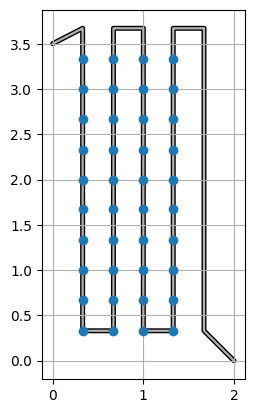

In [9]:
sg = subgraphs[0]
pipe = find_best_pipe(sg,model.pipes,model.graph.iter_nodes(),grid_size)
pipe._render()

In [10]:
def nodes_as_dict(nodes):
    for node in nodes:
        yield (node.id, {"x": node.x, "y": node.y})


def build_trav_graph(grid_size,pipe,subgraph):
    search_node_ids = tuple(subgraph | set(n.id for n in pipe.corners))
    _nodes = [n for n in model.graph.iter_nodes() if n.id in search_node_ids] + [pipe.input, pipe.output]
    g = nx.DiGraph()
    g.add_nodes_from(nodes_as_dict(_nodes))
    for i, node in enumerate(_nodes):
        for other_node in _nodes[:]:
            if node.id != other_node.id and node.is_neighbor(other_node, grid_size):
                g.add_edge(node.id, other_node.id)
    g.add_nodes_from(nodes_as_dict([pipe.input,pipe.output]))
    g.add_edge(pipe.input.id, pipe.corners[0].id)
    g.add_edge( pipe.corners[-1].id,pipe.output.id)
    return g

In [11]:
trav_graph = build_trav_graph(grid_size,pipe,sg)
# #####################
# search_node_ids = tuple(sg | set(n.id for n in pipe.corners))
# _nodes = [n for n in model.graph.iter_nodes() if n.id in search_node_ids] + [pipe.input, pipe.output]
# layout = {node.id: (node.x, node.y) for node in _nodes}
# # for connector in self.connectors:
# #     for node in connector.iter_nodes():
# #         layout[node.id] = (node.x, node.y)
# nx.draw(trav_graph, pos=layout, node_size=20, node_color="grey")


In [12]:
def get_weight(x,visited_nodes,direction_bias):
    x0,y0 = visited_nodes[-1].split("_")[:2]
    x1,y1 = x.split("_")[:2]
    _dir = (abs(float(x1)-float(x0)),abs(float(y1)-float(y0)))
    match direction_bias, round(_dir[0],1), round(_dir[1],1):
        case "h", 0.0, _:
            return 1
        case "h", _, 0.0:
            return 0
        case "h", _, _:
            return 0.0
        case "v", 0.0, _:
            return 0
        case "v", _, 0.0:
            return 1
        case "v", _, _:
            return 0

def prune(possible_next, visited_nodes,graph):
    """
    Prune the list of possible next nodes based on the visited nodes.
    This function can be customized to implement specific pruning logic.
    """
    possible_next =  [n for n in possible_next if n not in visited_nodes] # remove visited nodes
    return possible_next

def solve(graph, visited, goal_node, direction_bias="v"):
    """
    A DFS/backtracking generator that yields all possible solutions from the
    current 'visited' path (a tuple) ending at visited[-1] to the goal_node.
    
    Parameters:
      graph: a directed graph object with method neighbors(node) that returns neighbors
      visited: a tuple of nodes representing the current path (e.g. (start_node,))
      goal_node: the target node that we're trying to reach
      direction_bias: (optional) a parameter to bias neighbor ordering via get_weight

    Yields:
      Each valid complete path (as a tuple) from the start to the goal_node.
    """
    # Base case: if current node is the goal, yield the current path.
    if visited[-1] == goal_node:
        yield visited
        return

    # Get candidate neighbors that haven't been visited in this path.

    possible_next = [n for n in graph.neighbors(visited[-1]) if n not in visited]
    
    # If there are no candidates, then this branch cannot extend; backtrack.
    if not possible_next:
        return

    # Sort the candidate nodes using a heuristic; this bias may help order paths.
    weighted = sorted(possible_next, key=lambda x: get_weight(x, visited, direction_bias))
    
    # For each candidate, extend the visited path and recursively yield from the deeper call.
    for node in weighted:
        new_path = visited + (node,)  # Create an extended path
        # Use 'yield from' to yield every solution from the recursive call.
        yield from solve(graph, new_path, goal_node, direction_bias)

In [13]:
import time
sol_gen = solve(trav_graph, (pipe.input.id,), pipe.output.id, "v")
s = time.time()
solutions = []
while time.time()-s < 10:
    try:
        solutions.append(next(sol_gen))
    except StopIteration:
        break

solutions = sorted(solutions, key=lambda x: len(x),reverse=True)


print(len(set(solutions)))
print(solutions[0])

208725
('2.0_0_NodeType.INPUT', '1.67_0.33_NodeType.GRID', '1.67_0.67_NodeType.GRID', '1.67_1.0_NodeType.GRID', '1.67_1.33_NodeType.GRID', '1.67_1.67_NodeType.GRID', '1.67_2.0_NodeType.GRID', '1.67_2.33_NodeType.GRID', '1.67_2.67_NodeType.GRID', '1.67_3.0_NodeType.GRID', '1.67_3.33_NodeType.GRID', '1.67_3.67_NodeType.GRID', '1.33_3.67_NodeType.GRID', '1.33_3.33_NodeType.GRID', '1.33_3.0_NodeType.GRID', '1.33_2.67_NodeType.GRID', '1.33_2.33_NodeType.GRID', '1.33_2.0_NodeType.GRID', '1.33_1.67_NodeType.GRID', '1.33_1.33_NodeType.GRID', '1.33_1.0_NodeType.GRID', '1.33_0.67_NodeType.GRID', '1.33_0.33_NodeType.GRID', '1.0_0.33_NodeType.GRID', '1.0_0.67_NodeType.GRID', '1.0_1.0_NodeType.GRID', '1.0_1.33_NodeType.GRID', '1.0_1.67_NodeType.GRID', '1.0_2.0_NodeType.GRID', '1.0_2.33_NodeType.GRID', '1.0_2.67_NodeType.GRID', '1.0_3.0_NodeType.GRID', '1.0_3.33_NodeType.GRID', '1.0_3.67_NodeType.GRID', '0.67_3.67_NodeType.GRID', '0.67_3.33_NodeType.GRID', '0.67_3.0_NodeType.GRID', '0.67_2.67_NodeTy

In [14]:
from networkx.algorithms.approximation import traveling_salesman_problem,greedy_tsp,christofides
from opti_pipe.models import Pipe
from shapely.geometry import LineString
from shapely.plotting import plot_line
from functools import partial


path = solutions[0]

nodes = tuple(model.graph.nodes) + tuple([pipe.input, pipe.output]) + tuple(pipe.corners)
path_nodes = [next(filter(lambda x: x.id == node_id, nodes), None) for node_id in path]
path_line = LineString([node.geometry for node in path_nodes[:]])


nx.draw(trav_graph, pos=layout, node_size=20, node_color="grey")
plot_line(path_line, color="red", linewidth=2)


NameError: name 'layout' is not defined

In [ ]:
pipe = Pipe.from_path(config, path_nodes, model.distributor)
